<a href="https://colab.research.google.com/github/agelos9/Dense-models/blob/main/pytorch_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up and mount Google Colab

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. '/Machine_Learning_for_EO_IGARSS_Summerschool/'
FOLDERNAME = '/Machine_Learning_for_EO_IGARSS_Summerschool/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
import os
sys.path.append(os.path.join('/content/drive/MyDrive/', FOLDERNAME))

# This downloads EuroSAT dataset to your Drive
# if it doesn't already exist. Uncomment to run!
%cd /content/drive/MyDrive/$FOLDERNAME/data/
!bash get_datasets.sh

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Machine_Learning_for_EO_IGARSS_Summerschool/data
--2024-07-05 18:17:29--  https://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  17.5MB/s    in 8.4s    

2024-07-05 18:17:39 (10.7 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]



In [ ]:
%cd ..

/content/drive/MyDrive/Machine_Learning_for_EO_IGARSS_Summerschool


In [ ]:
# Let's have a look on what we have downloaded
%ls data/

EuroSAT/  get_datasets.sh


In [ ]:
# Let's have a look on the classes
%ls data/EuroSAT/

AnnualCrop/  HerbaceousVegetation/  Industrial/  PermanentCrop/  River/
Forest/      Highway/               Pasture/     Residential/    SeaLake/


In [ ]:
# Let's have a look on the images of the class AnnualCrop
%ls data/EuroSAT/AnnualCrop/

ls: cannot access 'data/EuroSAT/AnnualCrop/': No such file or directory


In [ ]:
# Change directory to where your unzipped assignment folder is
%cd /content/drive/MyDrive/$FOLDERNAME

/content/drive/MyDrive/Machine_Learning_for_EO_IGARSS_Summerschool


# Introduction to PyTorch

For this exercise, though, we're going to use the popular deep learning framework: [PyTorch](https://pytorch.org/)!

## Why do we use deep learning frameworks?

* Our code will run on GPUs! This will allow our models to train much faster. When using a framework like PyTorch or TensorFlow you can harness the power of the GPU for your own custom neural network architectures without having to write CUDA code directly (which is beyond the scope of this class).
* In this class, we want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand.
* We want you to stand on the shoulders of giants! PyTorch is an amazing framework that will make your life a lot easier, and now that you understand its guts, you are free to use it 😊
* Finally, we want you to be exposed to the sort of deep learning code you might run into in academia or industry.

## What is PyTorch?

PyTorch is a system for executing dynamic computational graphs over Tensor objects that behave similarly as numpy ndarray. It comes with a powerful automatic differentiation engine that removes the need for manual back-propagation.

## How do I learn PyTorch?

Justin Johnson has made an excellent [tutorial](https://github.com/jcjohnson/pytorch-examples) for PyTorch.

You can also find the detailed [API doc](http://pytorch.org/docs/stable/index.html) here.

If you have other questions that are not addressed by the API docs, the [PyTorch forum](https://discuss.pytorch.org/) is a much better place to ask than StackOverflow.

# Table of Contents


This assignment has 3 parts. You will learn PyTorch on **two different levels of abstraction**, which will help you understand it better and prepare you for the final open-ended challenge.

1. Part I, Preparation: we will use EuroSAT dataset.
2. Part III, PyTorch Module API: **Abstraction level 2**, we will use `nn.Module` to define arbitrary neural network architecture.
3. Part IV, PyTorch Sequential API: **Abstraction level 3**, we will use `nn.Sequential` to define a linear feed-forward network very conveniently.

Here is a table of comparison:

| API           | Flexibility | Convenience |
|---------------|-------------|-------------|
| `nn.Module`     | High        | Medium      |
| `nn.Sequential` | Low         | High        |

# GPU

You can manually switch to a GPU device on Colab by clicking `Runtime -> Change runtime type` and selecting `GPU` under `Hardware Accelerator`.

## Setup

You should switch to GPU before running the following cells to import packages, since the kernel gets restarted upon switching runtimes.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as datasets
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cuda


# Part I. Preparation

Now, let's load the EuroSAT dataset. This might take a couple minutes the first time you do it, but the files should stay cached after that. PyTorch provides some convenient tools to automate this process even more for us.

$\color{pink}{\textit Code Question:}$

Load EuroSAT dataset and split it into train, val and test splits:

In [28]:
# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
mean = (0.3442, 0.3802, 0.4077)
std = (0.2033, 0.1363, 0.1145)
# Data augmentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

#transform = T.Compose([
#                T.ToTensor(),
#                T.Normalize(mean, std)
#            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the EuroSAT
# dataset into train, val and test sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.

dataset_path = '/content/drive/MyDrive/Machine_Learning_for_EO_IGARSS_Summerschool/data/EuroSAT/'

eurosat_dataset = datasets.ImageFolder(dataset_path, transform=transform)

num_train = 23300
num_val = 2700
num_test = 1000


# Extract labels for stratification
labels = [y for _, y in eurosat_dataset.samples]

# Extract indices
indices = list(range(len(eurosat_dataset)))

# First split to separate out the training data
train_indices, remaining_indices, train_labels, remaining_labels = train_test_split(indices, labels, train_size=num_train, stratify=labels)

# Second split to divide the remaining data into validation and test
val_indices, test_indices, val_labels, test_labels = train_test_split(remaining_indices, remaining_labels, train_size=num_val, stratify=remaining_labels)

# Initialize DataLoaders with the stratified indices
train_loader = DataLoader(eurosat_dataset, batch_size=64, sampler=sampler.SubsetRandomSampler(train_indices))
val_loader = DataLoader(eurosat_dataset, batch_size=64, sampler=sampler.SubsetRandomSampler(val_indices))
test_loader = DataLoader(eurosat_dataset, batch_size=64, sampler=sampler.SubsetRandomSampler(test_indices))

CHALLENGE CODE

In [31]:
# Helper functions

In [32]:
def check_accuracy_eurosat_challenge(loader, model):
    num_correct, num_samples = 0, 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [33]:
def train_eurosat_challenge(model, optimizer, epochs=1):
    """
    Train a model on EuroSAT using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_eurosat_challenge(val_loader, model)
                print()

In [37]:
################################################################################
# TODO:                                                                        #
# Experiment with any architectures, optimizers, and hyperparameters.          #
# Achieve AT LEAST 80% accuracy on the *validation set*.                       #
#                                                                              #
# Note that you can use the check_accuracy function to evaluate on either      #
# the test set or the validation set, by passing either val_loader or          #
# test_loader as the second argument to check_accuracy. You should not touch   #
# the test set until you have finished your architecture and hyperparameter    #
# tuning, and only run the test set once at the end to report a final value.   #
################################################################################
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F

import torchvision.datasets as datasets
import torchvision.transforms as T

model = None
optimizer = None

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
'''def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

channel_1 = 32
channel_2 = 16
learning_rate = 1e-5

model = nn.Sequential(
    nn.Conv2d(3, channel_1, 5, padding=2),
    nn.ReLU(),
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    Flatten(),
    nn.Linear(channel_2 * 64 * 64, 10)
)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
'''
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

# Data augmentation
#transform = transforms.Compose([
#    transforms.RandomResizedCrop(64),
#    transforms.RandomHorizontalFlip(),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#])

# Improved model
class ImprovedModel(nn.Module):
    def __init__(self):
        super(ImprovedModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = ImprovedModel()

# Optimizer with weight decay
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

# Training loop (example)
# Assuming `train_loader` is your DataLoader for training data
# num_epochs = 20
# criterion = nn.CrossEntropyLoss()
# for epoch in range(num_epochs):
#     model.train()
#     for inputs, targets in train_loader:
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# You should get at least 80% accuracy
# You might be able to achieve this with fewer than 10 epochs :)
train_eurosat_challenge(model, optimizer, epochs=1)

Iteration 0, loss = 2.3666
Got 350 / 2700 correct (12.96)

Iteration 100, loss = 1.2677
Got 1793 / 2700 correct (66.41)

Iteration 200, loss = 0.7882
Got 2029 / 2700 correct (75.15)

Iteration 300, loss = 0.8764
Got 2055 / 2700 correct (76.11)



In [36]:
# Test model
best_model = model
check_accuracy_eurosat_challenge(test_loader, best_model)

Got 892 / 1000 correct (89.20)


$\color{pink}{\textit Code Question:}$

Let's now visualize 10 images per class.

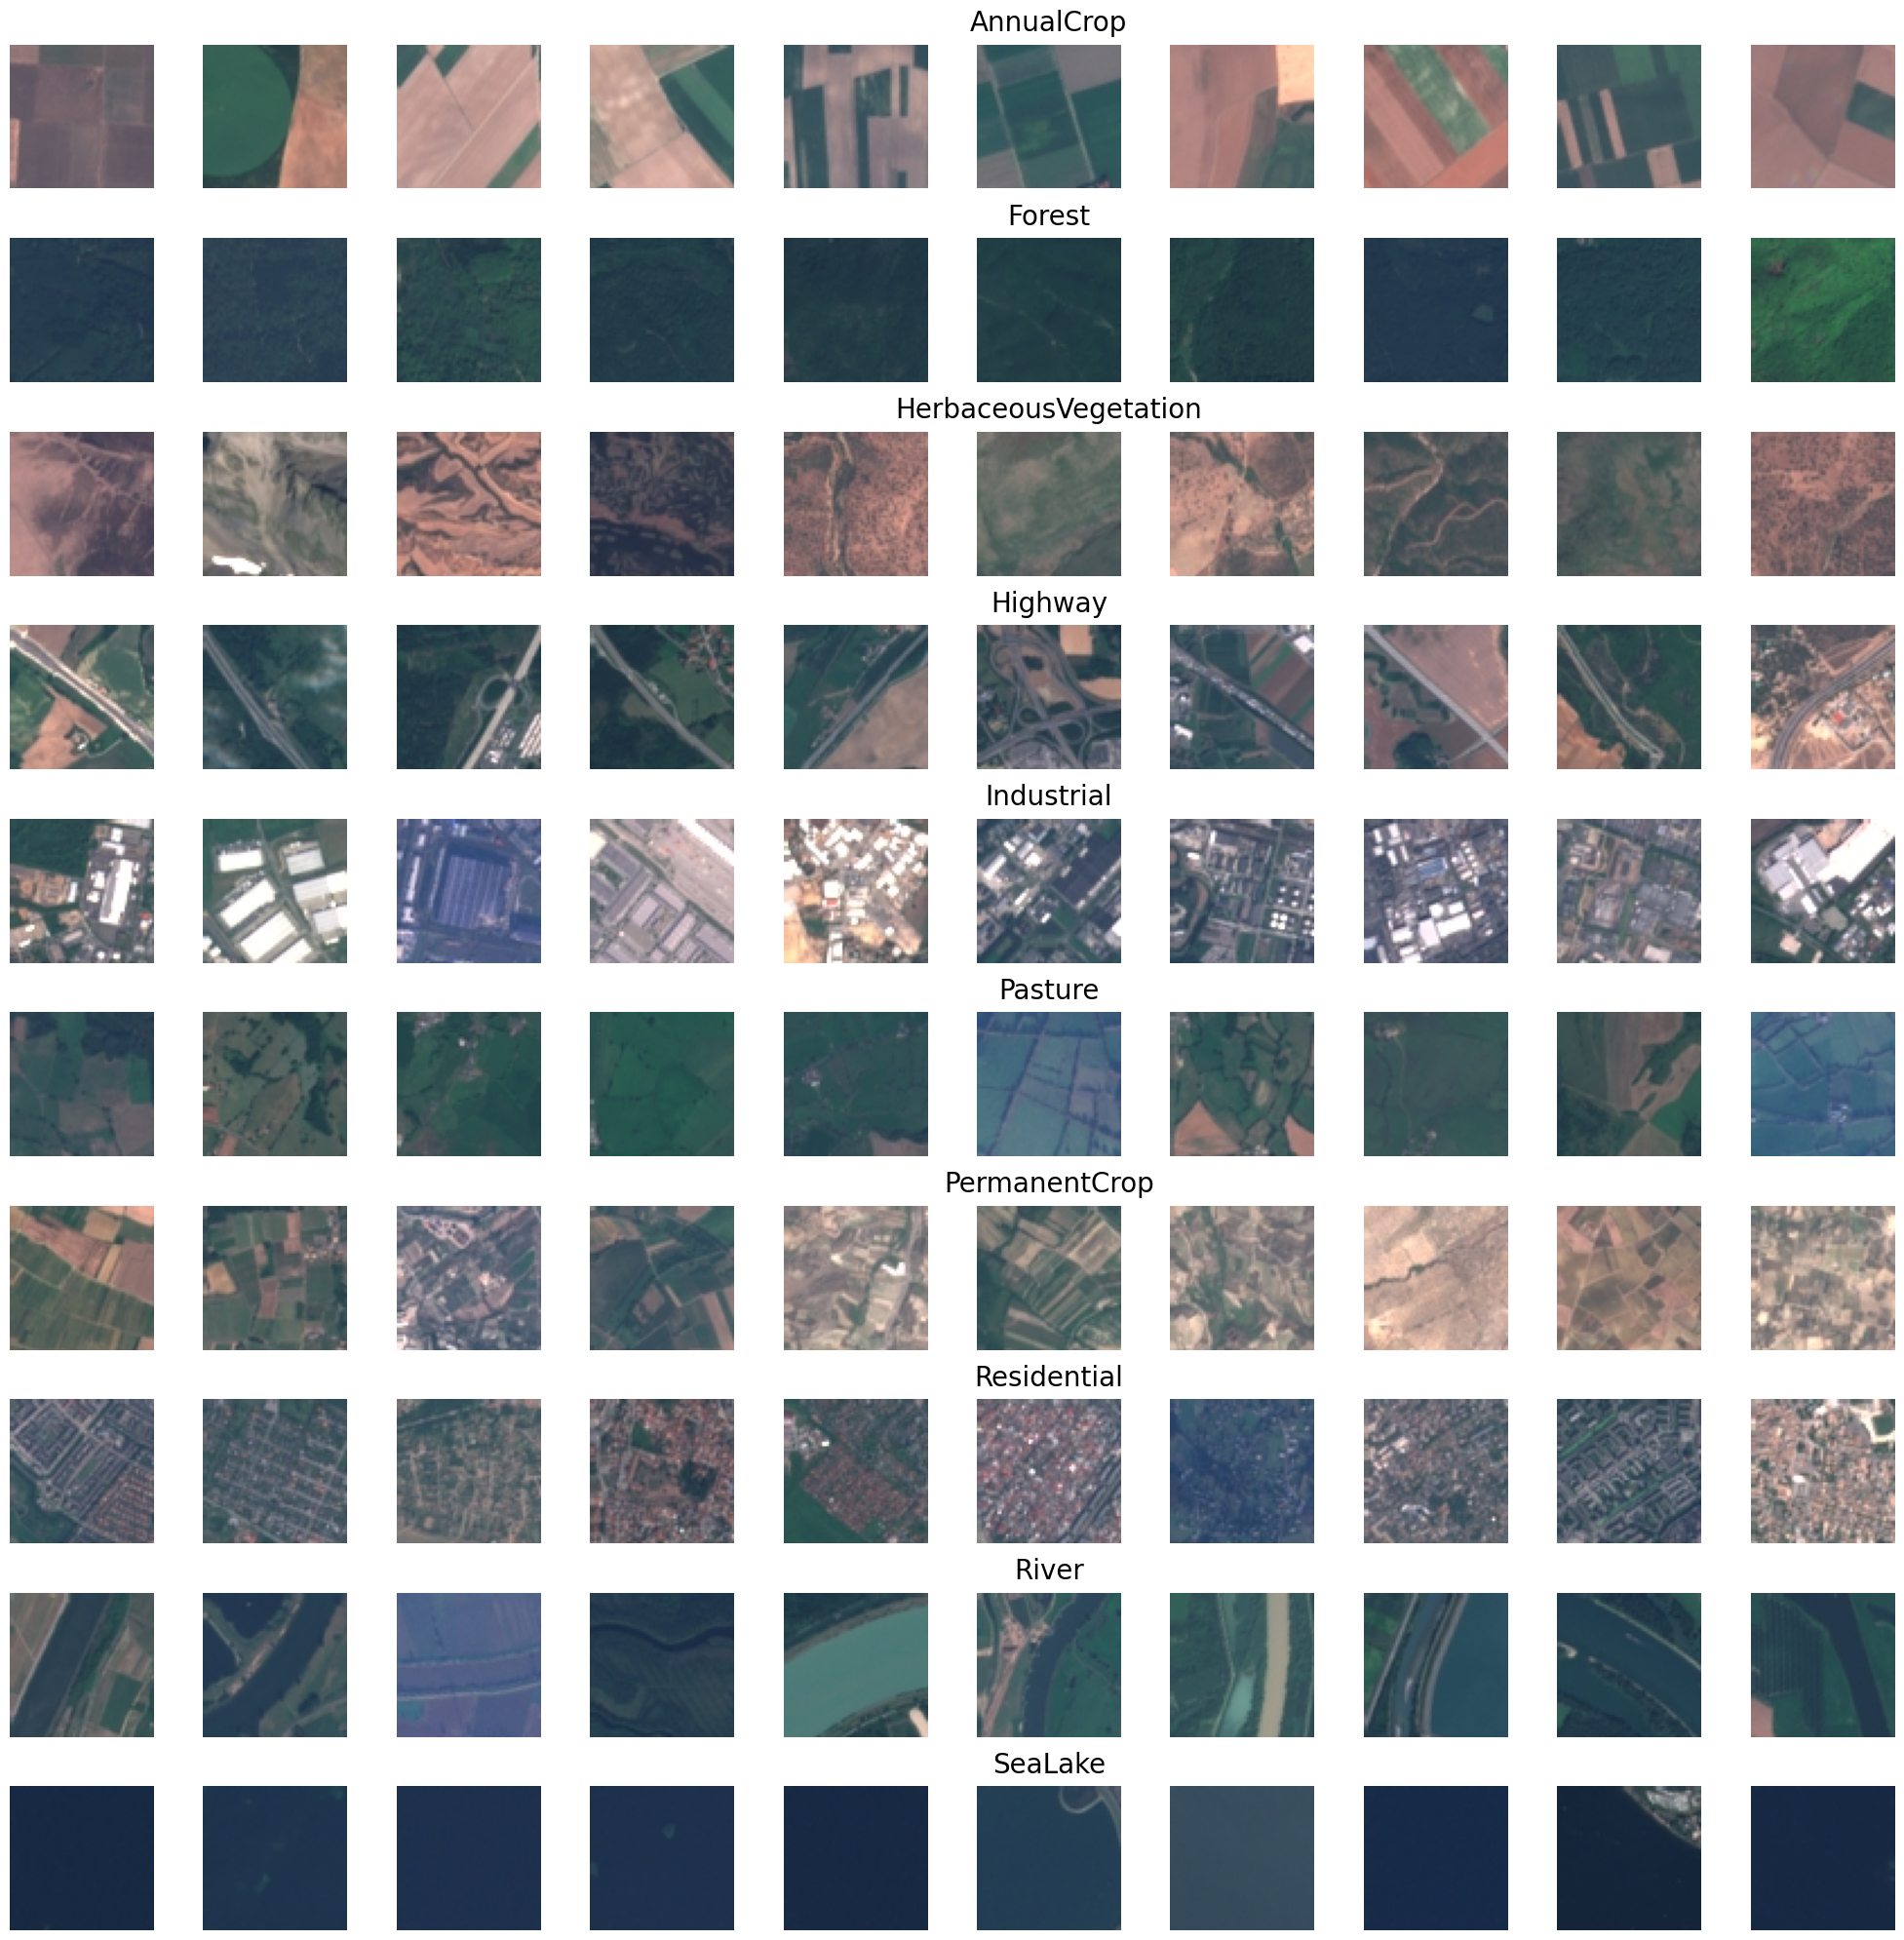

In [ ]:
# Define the inverse normalization transform
inv_transform = T.Compose([
    T.Normalize(mean=[0, 0, 0], std=[1/s for s in std]),
    T.Normalize(mean=[-m for m in mean], std=[1, 1, 1])
])

# Function to perform inverse normalization
def inv_normalize(img):
    return inv_transform(img)

# Prepare to plot 10 images per class
num_classes = len(eurosat_dataset.classes)
images_per_class = 10

# Collecting images
class_indices = {cls: [] for cls in range(num_classes)}
for idx, label in enumerate(labels):
    if len(class_indices[label]) < images_per_class:
        class_indices[label].append(idx)
    if all(len(class_indices[cls]) == images_per_class for cls in range(num_classes)):
        break

# Plotting the images
fig, axes = plt.subplots(num_classes, images_per_class, figsize=(images_per_class * 2, num_classes * 2))
for class_id, indices in class_indices.items():
    for i, idx in enumerate(indices):
        img, label = eurosat_dataset[idx]
        img = inv_normalize(img)
        img = img.permute(1, 2, 0).numpy()  # Convert to HWC format for plotting
        axes[class_id, i].imshow(img)
        axes[class_id, i].axis('off')
    # Add class name label in the middle of the row
    mid_index = images_per_class // 2
    axes[class_id, mid_index].set_title(eurosat_dataset.classes[class_id], fontsize=20, pad=10)

plt.tight_layout()
plt.show()

We have now defined our train, validation and test dataloaders using `sampler.SubsetRandomSampler`.

However, it would be good to check the data distribution of each set, in order to check how many examples per class are included. We do this as a sanity check, as we want our sets to be distributed close to uniform.

$\color{pink}{\textit Code Question:}$

Let's write code to check the data distribution of each set:

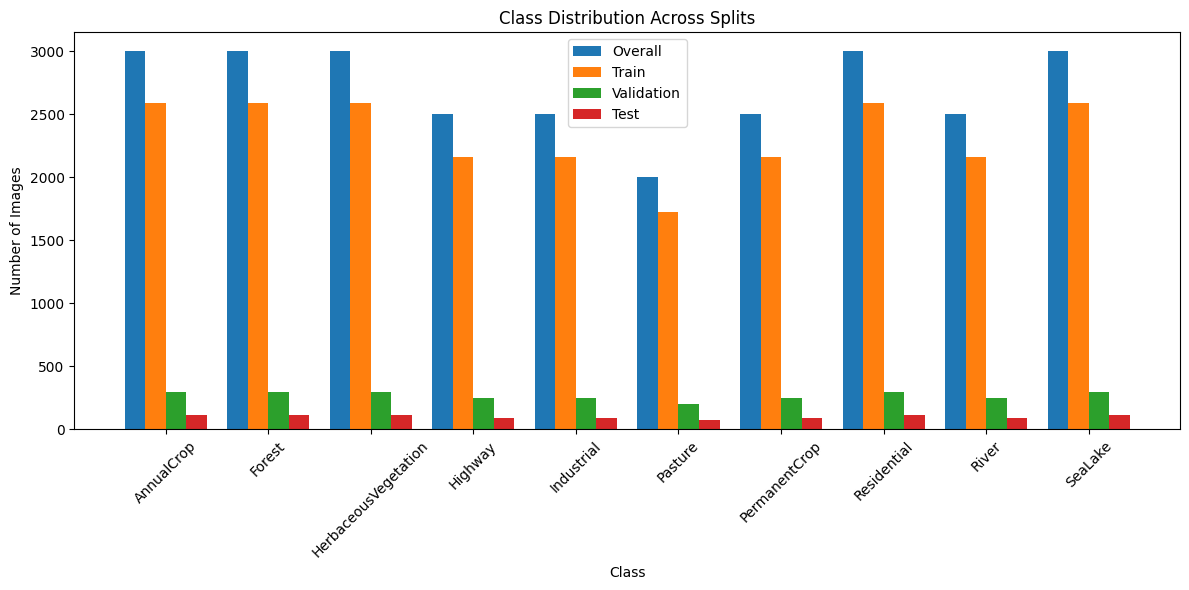

In [ ]:
# Get unique counts for the entire dataset
unique_labels, counts_labels = np.unique(labels, return_counts=True)

# Get unique counts for each dataset
train_unique, train_counts = np.unique(train_labels, return_counts=True)
val_unique, val_counts = np.unique(val_labels, return_counts=True)
test_unique, test_counts = np.unique(test_labels, return_counts=True)

# Ensure all classes are represented
all_classes = np.arange(max(train_unique.max(), val_unique.max(), test_unique.max()) + 1)
train_counts_complete = np.array([train_counts[train_unique.tolist().index(cls)] if cls in train_unique else 0 for cls in all_classes])
val_counts_complete = np.array([val_counts[val_unique.tolist().index(cls)] if cls in val_unique else 0 for cls in all_classes])
test_counts_complete = np.array([test_counts[test_unique.tolist().index(cls)] if cls in test_unique else 0 for cls in all_classes])

# Ensure all classes are represented
counts_labels_complete = np.array([counts_labels[unique_labels.tolist().index(cls)] if cls in unique_labels else 0 for cls in all_classes])

# Plotting the data with the overall dataset first
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(all_classes))

plt.bar(index, counts_labels_complete, bar_width, label='Overall')
plt.bar(index + bar_width, train_counts_complete, bar_width, label='Train')
plt.bar(index + 2 * bar_width, val_counts_complete, bar_width, label='Validation')
plt.bar(index + 3 * bar_width, test_counts_complete, bar_width, label='Test')

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution Across Splits')
plt.xticks(index + 1.5 * bar_width, eurosat_dataset.classes, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Part II. Two-Layer Network with PyTorch Module API

PyTorch provides the `nn.Module` API for you to define arbitrary network architectures, while tracking every learnable parameters for you. PyTorch also provides the `torch.optim` package that implements all the common optimizers, such as RMSProp, Adagrad, and Adam. You can refer to the [doc](http://pytorch.org/docs/master/optim.html) for the exact specifications of each optimizer.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`. Give your network class an intuitive name like `TwoLayerFC`.

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` are themselves `nn.Module` subclasses and contain learnable parameters, so that you don't have to instantiate the raw tensors yourself. `nn.Module` will track these internal parameters for you. Refer to the [doc](http://pytorch.org/docs/master/nn.html) to learn more about the dozens of builtin layers. **Warning**: don't forget to call the `super().__init__()` first!

3. In the `forward()` method, define the *connectivity* of your network. You should use the attributes defined in `__init__` as function calls that take tensor as input and output the "transformed" tensor. Do *not* create any new layers with learnable parameters in `forward()`! All of them must be declared upfront in `__init__`.

After you define your Module subclass, you can instantiate it as an object and call it just like the NN forward function in part II.

### Module API: Two-Layer Network

### PyTorch Tensors: Flatten Function
A PyTorch Tensor is conceptionally similar to a numpy array: it is an n-dimensional grid of numbers, and like numpy PyTorch provides many functions to efficiently operate on Tensors. As a simple example, we provide a `flatten` function below which reshapes image data for use in a fully-connected neural network.

Recall that image data is typically stored in a Tensor of shape N x C x H x W, where:

* N is the number of datapoints
* C is the number of channels
* H is the height of the intermediate feature map in pixels
* W is the height of the intermediate feature map in pixels

This is the right way to represent the data when we are doing something like a 2D convolution, that needs spatial understanding of where the intermediate features are relative to each other. When we use fully connected affine layers to process the image, however, we want each datapoint to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data. So, we use a "flatten" operation to collapse the `C x H x W` values per representation into a single long vector. The flatten function below first reads in the N, C, H, and W values from a given batch of data, and then returns a "view" of that data. "View" is analogous to numpy's "reshape" method: it reshapes x's dimensions to be N x ??, where ?? is allowed to be anything (in this case, it will be C x H x W, but we don't need to specify that explicitly).

In [ ]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


$\color{pink}{\textit Code Question:}$

Let's implement a two-layer fully connected neural network using PyTorch's `nn.Module` API. The network should consist of two linear layers with a ReLU activation function in between, exactly as we did earlier using barebone PyTorch. Your task is to fill in the missing parts of the provided code template to define the network's architecture and its forward pass.

Network Architecture:
- The network should have one hidden layer.
- The input layer takes inputs of a specified size and feeds them into the hidden layer.
- The hidden layer should use ReLU as its activation function.
- The output layer produces scores for a specified number of classes.

Initialization:
- Initialize the weights of both linear layers using the Kaiming normalization method, which is suitable for layers followed by a ReLU activation function.

Forward Pass:
- Your implementation should include a forward method that defines how data passes through the network.

In [ ]:
import torch
import torch.nn.functional as F

##############################################################################
# TODO: Define a TwoLayerFC class using nn.Module. The class should include  #
# an __init__() and a forward() method.                                      #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # assign layer objects to class attributes
        self.fc1 = nn.Linear(input_size, hidden_size)
        # nn.init package contains convenient initialization methods
        # http://pytorch.org/docs/master/nn.html#torch-nn-init
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        # forward always defines connectivity
        x = flatten(x)
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

Now, let's test the implementation!

In [ ]:
def test_TwoLayerFC():
    input_size = 50
    x = torch.zeros((64, input_size), dtype=dtype)  # minibatch size 64, feature dimension 50
    model = TwoLayerFC(input_size, 42, 10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]

test_TwoLayerFC()

torch.Size([64, 10])


### Module API: Check Accuracy

Given the validation or test set, we can again check the classification accuracy of the neural network.

$\color{pink}{\textit Code Question:}$

In this question, we will define function `check_accuracy`, which evaluates the accuracy of a classification model on a given dataset split (validation or test) using PyTorch's object-oriented `Module API`.

In [ ]:
##############################################################################
# TODO: Define check_accuracy to be compatible with nn.Module API.   #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
def check_accuracy(loader, model):
    num_correct, num_samples = 0, 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

### Module API: Training Loop

For the training loop, we use an Optimizer object from the `torch.optim` package, which abstracts the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [ ]:
def train(model, optimizer, epochs=1):
    """
    Train a model on EuroSAT using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy(val_loader, model)
                print()

### Module API: Train a Two-Layer Network

$\color{pink}{\textit Code Question:}$

Now we are ready to run the training loop.

Simply pass the input size, hidden layer size, and number of classes (i.e. output size) to the constructor of `TwoLayerFC`.

You also need to define an optimizer that tracks all the learnable parameters inside `TwoLayerFC`.

You don't need to tune any hyperparameters.

Train for one epoch!

In [ ]:
hidden_layer_size = 20
learning_rate = 1e-4
model = TwoLayerFC(3 * 64 * 64, hidden_layer_size, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train(model, optimizer)

# Part III. Two-Layer Network with PyTorch Sequential API

Part II introduced the PyTorch Module API, which allows you to define arbitrary learnable layers and their connectivity.

For simple models like a stack of feed forward layers, you still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. Is there a more convenient way?

Fortunately, PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one. It is not as flexible as `nn.Module`, because you cannot specify more complex topology than a feed-forward stack, but it's good enough for many use cases.

### Sequential API: Two-Layer Network

$\color{pink}{\textit Code Question:}$

Let's see how to rewrite our two-layer fully connected network example with `nn.Sequential`, and train it using the training loop defined above.

Again, you don't need to tune any hyperparameters.

Train for one epoch!

In [ ]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

hidden_layer_size = 20
learning_rate = 1e-3

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 64 * 64, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, 10),
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train(model, optimizer)

$\color{pink}{\textit Code Question:}$

Given the baseline model implemented with PyTorch's Sequential API (as defined above), your task is to train this model for 1 epoch using as **optimizers**: `SGD`, `SGD with momentum`, `Adagrad`, `RMSProp`, `Adam`, `AdamW` and `NAdam`.

To do this, you have to have a look at the PyTorch documentation about [optimizers](https://pytorch.org/docs/stable/optim.html.). Utilize the `train_part2` function.

For your convenience, use `hidden_layer_size = 20`, so that computations take less time.



In [ ]:
##############################################################################
# TODO: Use train_part2 function to train the nn.Sequential 2-layer net      #
# for 1 epoch using different optimizers. Note to keep all the results.      #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

Keep all the classification results in the following Table:

| Optimizer | Accuracy |
|----------|----------|
| SGD    | ...   |
| SGD with momentum    | ...   |
| Adagrad    | ...   |
| RMSProp    | ...   |
| Adam    | ...   |
| AdamW    | ...   |
| NAdam    | ...   |



$\color{pink}{\textit Code Question:}$

Make use of the optimizer that gave the best results earlier, to train the same model for 1 epoch using as **activation functions**: `Leaky ReLU`, `ELU`, `GeLU`, `PReLU`, `SiLU` and `Mish`.

To do this, you have to have a look at the PyTorch documentation about [non-linear activations](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).

For your convenience, use again `hidden_layer_size = 20`, so that computations take less time.

In [ ]:
##############################################################################
# TODO: Use train_part2 function to train the nn.Sequential 2-layer net      #
# for 1 epoch using different activations. Note to keep all the results.     #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

Keep all the classification results in the following Table:

| Activation function | Accuracy |
|----------|----------|
| ReLU    | ...   |
| Leaky ReLU    | ...   |
| ELU    | ...   |
| GeLU    | ...   |
| PReLU    | ...   |
| SiLU    | ...   |
| Mish    | ...   |



# Part IV. Three-layer Convolutional Network with PyTorch Module API

$\color{pink}{\textit Code Question:}$

Let's implement a 3-layer ConvNet followed by a fully connected layer:

1. Convolutional layer with `channel_1` 5x5 filters with zero-padding of 2
2. ReLU
3. Convolutional layer with `channel_2` 3x3 filters with zero-padding of 1
4. ReLU
5. Fully-connected layer to `num_classes` classes

You should initialize the weight matrices of the model using the Kaiming normal initialization method.

**HINT**: http://pytorch.org/docs/stable/nn.html#conv2d

After you implement the three-layer ConvNet, the `test_ThreeLayerConvNet` function will run your implementation; it should print `(64, 10)` for the shape of the output scores.

In [ ]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
        ########################################################################
        # TODO: Set up the layers you need for a three-layer ConvNet with the  #
        # architecture defined above.                                          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.conv1 = nn.Conv2d(in_channel, channel_1, 5, padding=2)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(channel_1, channel_2, 3, padding=1)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.fc = nn.Linear(channel_2 * 64 * 64, num_classes)
        nn.init.kaiming_normal_(self.fc.weight)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                          END OF YOUR CODE                            #
        ########################################################################

    def forward(self, x):
        scores = None
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        scores = self.fc(flatten(x))
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores


def test_ThreeLayerConvNet():
    x = torch.zeros((64, 3, 64, 64), dtype=dtype)  # minibatch size 64, image size [3, 64, 64]
    model = ThreeLayerConvNet(in_channel=3, channel_1=12, channel_2=8, num_classes=10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]

test_ThreeLayerConvNet()

torch.Size([64, 10])


### Module API: Train a Three-Layer ConvNet

$\color{pink}{\textit Code Question:}$

Let's now use the Module API to train a three-layer ConvNet on EuroSAT. This should look very similar to training the two-layer network! You don't need to tune any hyperparameters.

Train for one epoch!

We train the model using stochastic gradient descent without momentum.

In [ ]:
learning_rate = 3e-4
channel_1 = 32
channel_2 = 16

model = None
optimizer = None
################################################################################
# TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
model = ThreeLayerConvNet(3, channel_1, channel_2, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

train(model, optimizer)

# Part V. Three-layer Convolutional Network with PyTorch Sequential API

$\color{pink}{\textit Code Question:}$

Here we will use `nn.Sequential` to define and train a three-layer ConvNet with the same architecture we used above:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

We can use the default PyTorch weight initialization.

Let's optimize your model using stochastic gradient descent with Nesterov momentum 0.9.

Again, we don't need to tune any hyperparameters.

Train for one epoch!

In [ ]:
channel_1 = 32
channel_2 = 16
learning_rate = 1e-5

model = None
optimizer = None

################################################################################
# TODO: Rewrite the 2-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
model = nn.Sequential(
    nn.Conv2d(3, channel_1, 5, padding=2),
    nn.ReLU(),
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    Flatten(),
    nn.Linear(channel_2 * 64 * 64, 10)
)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

train(model, optimizer)